<a href="https://colab.research.google.com/github/dhkdsns20/Communication/blob/main/showmap_dijkstra_custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Path Finding Algorithm
## Find strongest path with thpt

In [4]:
pip install osmnx

In [26]:
# from pyrosm import OSM
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import folium
import heapq

# ## 사용함수 정의 ##
# # 도로 네트워크 생성 함수 정의(ver1)
# def fetch_map(place_name):
#     """
#     캠퍼스의 OSM 데이터를 가져와서 도로 네트워크를 생성하는 함수.

#     - place_name: 지도에서 검색할 위치 (캠퍼스 이름 등)

#     반환: 캠퍼스 도로 네트워크 그래프
#     """
#     # 주어진 위치를 기준으로 도로 네트워크를 다운로드
#     G = ox.graph_from_place(place_name, network_type="walk")  # 도보 네트워크 기준
#     return G

#  출발지 및 목적지 노드 설정 함수 정의
def get_nearest_node(G, latitude, longitude):
    """
    입력된 위도와 경도에 가장 가까운 그래프 노드를 찾는 함수.

    - G: 도로 네트워크 그래프
    - latitude: 위도
    - longitude: 경도

    반환: 가장 가까운 노드 ID
    """
    return ox.distance.nearest_nodes(G, longitude, latitude)

# 최단 경로 탐색 함수 정의
def find_shortest_path(G, origin_point, destination_point):
    """
    입력된 출발지와 목적지 간 최단 경로를 찾는 함수.

    - G: 도로 네트워크 그래프
    - origin_point: 출발지 좌표 (위도, 경도)
    - destination_point: 목적지 좌표 (위도, 경도)

    반환: 최단 경로 노드 리스트
    """
    # # 출발지와 목적지의 가장 가까운 노드 찾기
    # origin_node = get_nearest_node(G, *origin_point)
    # destination_node = get_nearest_node(G, *destination_point)

    # 최단 경로 계산 (Dijkstra 알고리즘)
    shortest_path = nx.shortest_path(G, origin_point, destination_point, weight='length',method="dijkstra") #
    return shortest_path


# 경로 시각화 함수 정의
def plot_route(G, path):
    """
    최단 경로를 그래프에 시각화하는 함수.

    - G: 도로 네트워크 그래프
    - path: 최단 경로 노드 리스트
    """
    fig, ax = ox.plot_graph_route(G, path, route_linewidth=2, node_size=0, bgcolor='k')
    plt.show()

# 도로만 남기는 함수
def create_filtered_graph(G, excluded_highway_types):
    """
    특정 highway 유형을 제외한 새로운 그래프를 반환하는 함수.

    - G: NetworkX 그래프
    - excluded_highway_types: 제외할 highway 유형 리스트 (예: ['footway'])

    반환: 제외된 엣지가 제거된 새로운 NetworkX 그래프
    """
    # 그래프 복사 (원본을 유지하기 위해)
    filtered_graph = G.copy()

    # 제거 대상 엣지 식별 및 제거
    edges_to_remove = [
        (u, v) for u, v, data in filtered_graph.edges(data=True)
        if data.get('highway') in excluded_highway_types
    ]
    filtered_graph.remove_edges_from(edges_to_remove)

    # print(f"Removed {len(edges_to_remove)} edges with highway types: {excluded_highway_types}")
    return filtered_graph

# 도로 네트워크 시각화 함수 정의 (Node ID 표시 추가) - 추가기능
def plot_map_with_node_ids(G, poi_coords=None):
    """
    도로 네트워크와 각 노드의 ID를 시각화하는 함수.

    - G: 도로 네트워크 그래프
    - poi_coords: POI 위치 좌표 리스트 (선택적)
    """
    # 도로 네트워크 시각화
    fig, ax = ox.plot_graph(G, show=False, close=False)

    i = 1
    # 각 노드의 위치에 Node ID를 표시
    for node, data in G.nodes(data=True):
        x, y = data['x'], data['y']
        if node == 10666146667 or node == 9274780719:
            ax.text(x, y, str(node), fontsize=8, color='blue')  # Node ID 표시

    # POI 위치 시각화 (있을 경우)
    if poi_coords:
        y, x = zip(*poi_coords)
        ax.scatter(x, y, c='red', s=30, label='POI')
        ax.legend()

    plt.show()

# throughput 데이터를 노드에 매핑하는 함수 정의
def map_throughput_to_nodes(G, throughput_excel):
    """
    throughput 데이터를 그래프 노드 속성으로 매핑하는 함수.

    - G: 도로 네트워크 그래프
    - throughput_excel: 노드 ID와 throughput 값을 가진 DataFrame

    반환: throughput 속성이 추가된 그래프
    """
    # 노드 ID를 문자열로 변환하여 통일
    throughput_excel['Node ID'] = throughput_excel['Node ID'].astype(str)

    for node, data in G.nodes(data=True):
        # 그래프 노드 ID도 문자열로 변환
        node_str = str(node)
        # 노드 ID와 일치하는 Throughput 값을 찾음
        throughput_value = throughput_excel.loc[throughput_excel['Node ID'] == node_str, 'Throughput (Mbps)'].values
        if len(throughput_value) > 0:
            G.nodes[node]['throughput'] = throughput_value[0]  # Throughput 값을 노드에 추가
        else:
            G.nodes[node]['throughput'] = 0  # 데이터가 없을 경우 0으로 설정
    return G






# thpt을 가중치로 하여 신호 세기가 강한 경로를 찾는 알고리즘 함수 생성

In [27]:
# 평균 가중치 (간선 수를 나눔)
# # ★ Custom 알고리즘 추가 ★
# def find_strongest_path(G, source, target):
#     """
#     Dijkstra 알고리즘을 수정하여 평균 가중치를 고려한 경로를 찾는 함수.

#     - G: NetworkX 그래프
#     - source: 출발 노드
#     - target: 도착 노드

#     반환:
#     - 최단 경로의 노드 리스트
#     - 경로의 평균 가중치
#     """
#     # 우선순위 큐 초기화
#     queue = [(0, 0, 0, source, [])]  # (평균 가중치, 누적 가중치, 간선 수, 현재 노드, 경로)
#     visited = set()

#     while queue:
#         avg_weight, cum_weight, num_edges, current_node, path = heapq.heappop(queue)

#         # 이미 방문한 노드는 무시
#         if current_node in visited:
#             continue
#         visited.add(current_node)

#         # 현재 노드를 경로에 추가
#         path = path + [current_node]

#         # 목표 노드에 도달하면 결과 반환
#         if current_node == target:
#             return path, avg_weight

#         # 인접 노드 탐색
#         for neighbor in G.neighbors(current_node):
#             edge_data = G[current_node][neighbor]

#             # 다중 간선 처리 - 최소 가중치 선택
#             min_edge_weight = float('inf')  # 초기값을 무한대로 설정
#             for key, data in edge_data.items():
#                 # throughput = G.nodes[neighbor].get('throughput', 0)
#                 # distance = data.get('length', float('inf'))
#                # 설정된 가중치를 직접 사용
#                 edge_weight = data.get('weight', float('inf'))
#                 if edge_weight is None:
#                     continue  # 가중치 없는 간선은 무시
#                 min_edge_weight = min(min_edge_weight, edge_weight)  # 최소 가중치 추적

#             # 최소 가중치를 기반으로 경로 확장
#             if min_edge_weight < float('inf'):  # 유효한 간선이 있는 경우
#                 new_cum_weight = cum_weight + min_edge_weight
#                 new_num_edges = num_edges + 1
#                 new_avg_weight = new_cum_weight / new_num_edges

#                 # 우선순위 큐에 추가
#                 heapq.heappush(queue, (new_avg_weight, new_cum_weight, new_num_edges, neighbor, path))

#     # 목표 노드에 도달하지 못한 경우
#     return None, float('inf')





# 누적 가중치를 고려한 함수
def find_strongest_path(G, source, target):
    """
    Dijkstra 알고리즘을 수정하여 누적 가중치를 고려한 경로를 찾는 함수.

    - G: NetworkX 그래프
    - source: 출발 노드
    - target: 도착 노드

    반환:
    - 최단 경로의 노드 리스트
    - 경로의 누적 가중치
    """
    # 우선순위 큐 초기화 (누적 가중치 기준)
    queue = [(0, source, [])]  # (누적 가중치, 현재 노드, 경로)
    visited = set()

    while queue:
        cum_weight, current_node, path = heapq.heappop(queue)

        # 이미 방문한 노드는 무시
        if current_node in visited:
            continue
        visited.add(current_node)

        # 현재 노드를 경로에 추가
        path = path + [current_node]

        # 목표 노드에 도달하면 결과 반환
        if current_node == target:
            return path, cum_weight

        # 인접 노드 탐색
        for neighbor in G.neighbors(current_node):
            edge_data = G[current_node][neighbor]

            # 최소 가중치 선택 (다중 간선 고려)
            min_edge_weight = float('inf')
            for key, data in edge_data.items():
                edge_weight = data.get('weight', float('inf'))
                if edge_weight is not None:
                    min_edge_weight = min(min_edge_weight, edge_weight)

            # 최소 가중치를 기반으로 경로 확장
            if min_edge_weight < float('inf'):
                new_cum_weight = cum_weight + min_edge_weight
                heapq.heappush(queue, (new_cum_weight, neighbor, path))

    return None, float('inf')




# # 가중치 계산 함수
# def calculate_weight(throughput, distance, ratio):
#     """
#     Throughput:거리 비율을 사용하여 가중치를 계산하는 함수.
#     - throughput: Throughput 값
#     - distance: 거리 값
#     - ratio: Throughput과 거리의 비율 (0~1)
#     """
#     # if throughput == 0:
#     #     return float('inf')
#     # if ratio == 0:  # 거리 중심일 경우
#     #     return distance
#     # elif ratio == 1:  # Throughput 중심일 경우
#     #     return 1 / throughput

#     # 거리와 Throughput이 혼합된 경우
#     return ratio * (1 / throughput) + (1 - ratio) * distance


# 가중치 계산 함수
def calculate_weight(throughput, distance, ratio):
    """
    - Throughput : Throughput 값
    - distance   : distance 값
    - ratio      : Throughput과 거리의 비율 (0~1)

    """
    # 최종 가중치 계산
    weight = (ratio * throughput) + ((1 - ratio) * distance)
    return weight



# 간선 가중치 설정 함수
def set_edge_weights_based_on_ratio(G, ratio):
    """
    간선의 가중치를 두 노드의 throughput 값과 거리 값의 비율로 설정하는 함수.
    - G: 도로 네트워크 그래프
    - ratio: Throughput:Distance 비율 (0~1)
    """

    for u, v, data in G.edges(data=True):
        # 노드의 throughput 값을 가져옴 (없으면 0으로 설정)
        throughput_u = G.nodes[u].get('throughput', 0)
        throughput_v = G.nodes[v].get('throughput', 0)
        distance = data.get('length', float('inf'))

        # 두 노드의 throughput 평균 계산
        avg_throughput = (throughput_u + throughput_v) / 2
        weight = calculate_weight(avg_throughput, distance, ratio)
        data['weight'] = weight
    return G




# # 간선 가중치를 ratio에 따라 설정하는 함수 정의
# def set_edge_weights_based_on_ratio(G, ratio):
#     """
#     간선의 가중치를 두 노드의 throughput 값과 거리 값의 비율로 설정하는 함수.
#     - G: 도로 네트워크 그래프
#     - ratio: Throughput:Distance 비율 (0~1)
#     """
#     for u, v, data in G.edges(data=True):
#         # 노드의 throughput 값을 가져옴 (없으면 0으로 설정)
#         pathloss_u = G.nodes[u].get('throughput', 0)
#         pathloss_v = G.nodes[v].get('throughput', 0)
#         distance = data.get('length', float('inf'))

#         # 두 노드의 throughput 평균 계산
#         avg_throughput = (pathloss_u + pathloss_v) / 2
#         weight = calculate_weight(avg_throughput, distance, ratio)
#         data['weight'] = weight
#     return G




- 충북대 osm 불러오기 및 src, target 지정

출발지 노드 ID (청주 시외버스터미널): 8485871892
목적지 노드 ID (충북대학교 병원): 6200628380


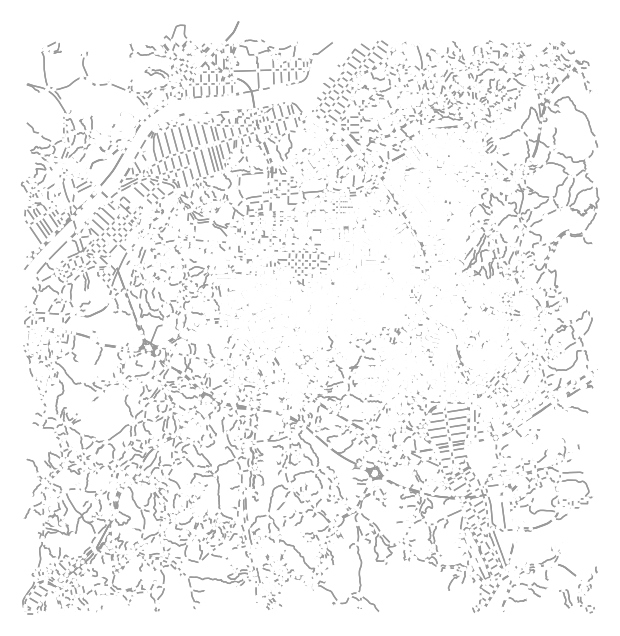

In [45]:
# 출발지 및 목적지 좌표 설정
origin = (36.6256453, 127.4314837)        # 청주 시외버스터미널
destination = (36.6246818, 127.4638686)   # 충북대학교 병원

# 중심 좌표 계산 (중간 지점)
center_lat = (origin[0] + destination[0]) / 2
center_lon = (origin[1] + destination[1]) / 2
center_point = (center_lat, center_lon)

# 반경 2km 도로 네트워크 불러오기
radius = 8000  # 반경 8km
cheongju_graph = ox.graph_from_point(center_point, dist=radius, network_type="walk")

# 출발지와 목적지의 가장 가까운 노드 찾기
origin_node = get_nearest_node(cheongju_graph, *origin)
destination_node = get_nearest_node(cheongju_graph, *destination)

print(f"출발지 노드 ID (청주 시외버스터미널): {origin_node}")
print(f"목적지 노드 ID (충북대학교 병원): {destination_node}")

# 시각화로 반경 확인
fig, ax = ox.plot_graph(cheongju_graph, bgcolor='white', node_size=10, edge_linewidth=1)

In [48]:
## 도보 제외한 네트워크 Graph 생성
# 제외할 highway 유형 설정
excluded_highways = ['footway']

# 필터링된 그래프 생성
filtered_graph = create_filtered_graph(cheongju_graph, excluded_highways)

- rxsite 노드 ID 반환 코드

In [31]:
# # 엑셀 파일 경로
# file_path = 'rxsite_throughput(Mbps).xlsx'

# # 엑셀 파일 로드
# rx_data = pd.read_excel(file_path)


# # Rx 좌표를 그래프에 노드로 추가하고 ID 반환
# def add_rx_node(lat, lon):
#     # 노드 추가 (위도, 경도를 이용)
#     node_id = ox.distance.nearest_nodes(G, lon, lat)
#     G.add_node(node_id, x=lon, y=lat)
#     return node_id

# # 각 Rx 좌표를 노드로 추가하고 Node ID를 DataFrame의 첫 열로 추가
# rx_data['Node ID'] = rx_data.apply(
#     lambda row: add_rx_node(row['RxLatitude'], row['RxLongitude']), axis=1
# )

# # Node ID 열을 가장 왼쪽으로 이동
# cols = ['Node ID'] + [col for col in rx_data.columns if col != 'Node ID']
# rx_data = rx_data[cols]

# # 결과 저장
# output_path = 'rxsite_throughput_with_node_id.xlsx'
# rx_data.to_excel(output_path, index=False)
# print(f"Node ID가 추가된 파일이 저장되었습니다: {output_path}")


Node ID가 추가된 파일이 저장되었습니다: rxsite_throughput_with_node_id.xlsx


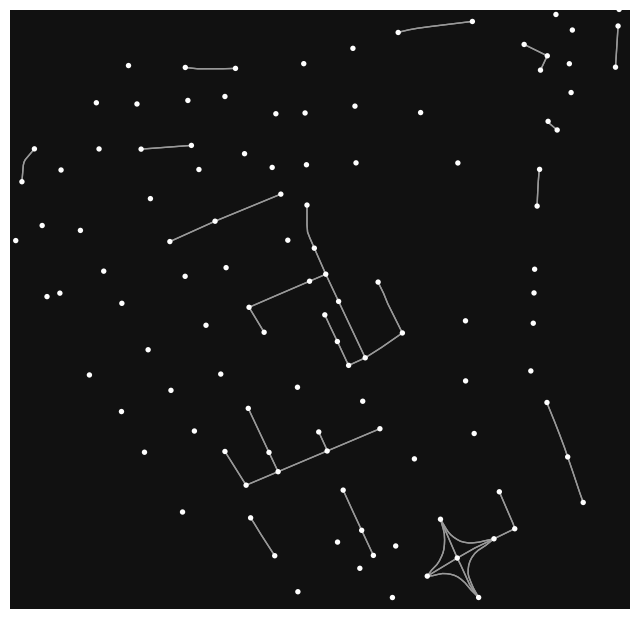

In [46]:
plot_map_with_node_ids(filtered_graph)

- 교차로의 노드 & 출발지/목적지 노드만 표시

In [ ]:
# Rx 노드 ID 불러오기
rx_file_path = 'rxsite_throughput_with_node_id.xlsx'
rx_data = pd.read_excel(rx_file_path)
rx_node_ids = rx_data['Node ID'].tolist()

# 출발지, 목적지, Rx 노드 ID 합치기
valid_node_ids = set(rx_node_ids + [origin_node, destination_node])

# Folium 지도 생성
m = folium.Map(location=center_point, zoom_start=15)

# 도로 네트워크를 Folium에 추가
for u, v, data in cheongju_graph.edges(data=True):
    # 각 간선의 좌표 가져오기
    points = [(cheongju_graph.nodes[u]['y'], cheongju_graph.nodes[u]['x']),
              (cheongju_graph.nodes[v]['y'], cheongju_graph.nodes[v]['x'])]
    # 간선을 Folium PolyLine으로 추가
    folium.PolyLine(points, color="blue", weight=2.5, opacity=0.7).add_to(m)

# 출발지 마커 추가
folium.Marker(
    location=origin,
    popup=f'Origin: {origin_node}',
    icon=folium.Icon(color='red', icon='play')
).add_to(m)

# 목적지 마커 추가
folium.Marker(
    location=destination,
    popup=f'Destination: {destination_node}',
    icon=folium.Icon(color='green', icon='flag')
).add_to(m)

# Rx 노드 마커 추가
for _, row in rx_data.iterrows():
    lat, lon, node_id = row['RxLatitude'], row['RxLongitude'], row['Node ID']
    folium.Marker(
        location=(lat, lon),
        popup=f'Rx Node: {node_id}',
        icon=folium.Icon(color='blue', icon='cloud')
    ).add_to(m)

# Folium 지도 저장 및 표시
m.save("cheongju_map.html")
m

# # 시각화 함수 개선
# def plot_filtered_graph(G, origin_node, destination_node, rx_node_ids):
#     fig, ax = plt.subplots(figsize=(12, 12))  # 그래프 크기 확대
#     ox.plot_graph(G, ax=ax, show=False, close=False, node_size=30, edge_linewidth=1, bgcolor='black')

#     # 출발지 노드 표시
#     x, y = G.nodes[origin_node]['x'], G.nodes[origin_node]['y']
#     ax.scatter(x, y, c='red', s=150, label='Origin', marker='o', edgecolors='white', linewidths=2)
#     ax.text(x + 0.0001, y + 0.0001, f'Origin\n{origin_node}', fontsize=12, color='red', ha='left', va='bottom')

#     # 목적지 노드 표시
#     x, y = G.nodes[destination_node]['x'], G.nodes[destination_node]['y']
#     ax.scatter(x, y, c='green', s=150, label='Destination', marker='o', edgecolors='white', linewidths=2)
#     ax.text(x + 0.0001, y + 0.0001, f'Destination\n{destination_node}', fontsize=12, color='green', ha='left', va='bottom')

#     # Rx 노드 표시
#     for node_id in rx_node_ids:
#         if node_id in G.nodes:
#             x, y = G.nodes[node_id]['x'], G.nodes[node_id]['y']
#             ax.scatter(x, y, c='blue', s=80, label=f'Rx Node {node_id}', marker='x')
#             ax.text(x + 0.0001, y + 0.0001, str(node_id), fontsize=8, color='blue', ha='left', va='bottom')

#     # 기타 노드 표시 (회색)
#     for node in G.nodes:
#         if node not in rx_node_ids and node != origin_node and node != destination_node:
#             x, y = G.nodes[node]['x'], G.nodes[node]['y']
#             ax.scatter(x, y, c='gray', s=10, alpha=0.5)

#     # 타이틀 설정
#     plt.suptitle("출발지, 목적지, Rx 노드만 포함된 도로 네트워크", fontsize=16, color='white')
#     plt.show()

# # 필터링된 그래프 시각화
# plot_filtered_graph(filtered_graph, origin_node, destination_node, rx_node_ids)

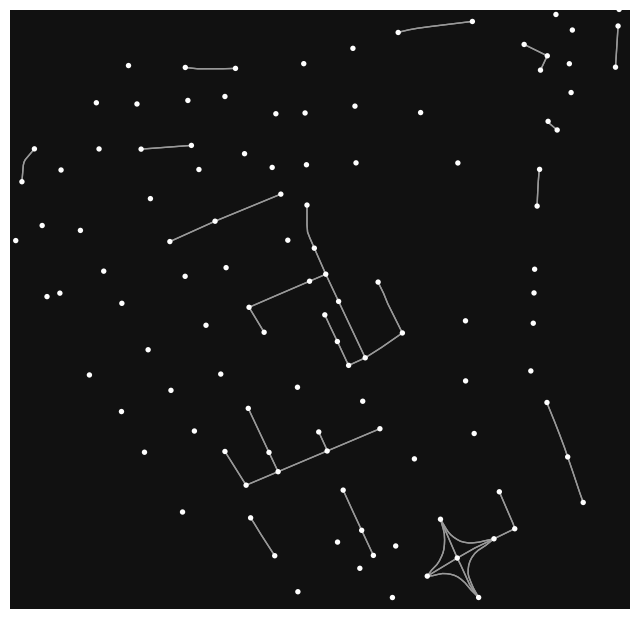

In [43]:
plot_map_with_node_ids(filtered_graph)

## Thpt 활용하여 위의 과정 반복

- thpt dataset 불러오기

In [16]:
# 엑셀 comm data(throughput) 불러오기
throughput_excel = pd.read_excel('rxsite_throughput_with_node_id.xlsx')

# throughput 정보를 노드에 매핑
G_set_node = map_throughput_to_nodes(filtered_graph, throughput_excel)


# comm data가 들어간 최종적인 네트워크 graph 생성
ratios = [0, 0.3, 0.6, 1]
titles = [
    "거리 중심 (0:1)",
    f'Throughput: 거리  ({ratios[1]}:{1-ratios[1]})',
    f'Throughput: 거리  ({ratios[2]}:{1-ratios[2]})',
    f'Throughput: 거리  ({ratios[3]}:{1-ratios[3]})'
]


# 경로 및 시각화
for ratio, title in zip(ratios, titles):
    # 비율에 따라 가중치 설정
    G_complete = set_edge_weights_based_on_ratio(G_set_node, ratio)

    # 경로 탐색
    strongest_path, avg_weight = find_strongest_path(G_complete, origin_node, destination_node)

    # 경로 시각화
    print(f"\n[{title}]\n")
    plot_route(G_complete, strongest_path)

    # 경로 정보 출력
    print(f"비율 {title} 경로: {strongest_path}\n")
    #print(f"평균 가중치: {avg_weight}\n")

    # 최단 경로를 거치는 모든 노드 수
    num_nodes_in_path = len(strongest_path)
    print(f"경로를 거치는 노드의 수: {num_nodes_in_path} 개")
    print("\n============================================================================================================================\n")


KeyError: 'Node ID'

- 정리표

In [17]:
def calculate_max_min_values(G):
    """
    그래프 G에서 최대 거리, 최소 거리, 최대 처리율, 최소 처리율을 계산하여 출력.
    """
    max_distance = float('-inf')
    min_distance = float('inf')
    max_throughput = float('-inf')
    min_throughput = float('inf')

    for u, v, data in G.edges(data=True):
        # 거리 값
        distance = data.get('length', float('inf'))

        # 노드의 throughput 값을 가져옴 (없으면 0으로 설정)
        throughput_u = G.nodes[u].get('throughput', 0)
        throughput_v = G.nodes[v].get('throughput', 0)

        # 두 노드의 throughput 평균 계산
        avg_throughput = (throughput_u + throughput_v) / 2

        # 최대, 최소 거리 업데이트
        max_distance = max(max_distance, distance)
        min_distance = min(min_distance, distance)

        # 최대, 최소 처리율 업데이트
        max_throughput = max(max_throughput, avg_throughput)
        min_throughput = min(min_throughput, avg_throughput)

    print("\n📊 최대/최소 값")
    print(f"최대 거리: {max_distance:.3f}")
    print(f"최소 거리: {min_distance:.3f}")
    print(f"최대 처리율: {max_throughput:.3f}")
    print(f"최소 처리율: {min_throughput:.3f}")

    return max_throughput, min_throughput, max_distance, min_distance

# 사용 예시
max_throughput, min_throughput, max_distance, min_distance = calculate_max_min_values(G_complete)


NameError: name 'G_complete' is not defined